##Big Data: Build Recommender System with Alternative Least Square Method using sparkML

1. Exploratory analysis to understand the structure/characteristics of the Data 
2. Prototying alternative least square (ALS) model to predict users' moive preference 
3. Productionalize the best ALS model to automate the recommender system

###1. Exploratory Analysis

1.1 Import Data and Perform Basic Checks

Description of the Data: The MovieLens Data, released 12/2019, contains 25 million movie ratings applied to 62,000 movies by 162,000 users. 
This data were used to build the recommender system.

In [5]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.mllib.recommendation import ALS

In [6]:
#initiate a spark session 
spark = SparkSession.builder.appName("movie recommendation").getOrCreate()

In [7]:
#read in the data 
movies = spark.read.csv("/FileStore/tables/full/movies.csv", header = True, inferSchema=True)
ratings = spark.read.csv("/FileStore/tables/full/ratings.csv", header = True, inferSchema=True)

In [8]:
#Number of Samples in each dataset 
print("The number of samples in movies data is:{}".format(movies.count()))
print("The number of samples in ratings data is:{}".format(ratings.count()))

The number of samples in movies data is:62423
The number of samples in ratings data is:25000095

In [9]:
#A quick look at the  data: movies 
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [10]:
#A quick look at the data: ratings 
ratings.show(5)

+------+-------+------+----------+
userId|movieId|rating| timestamp|
+------+-------+------+----------+
 1| 296| 5.0|1147880044|
 1| 306| 3.5|1147868817|
 1| 307| 5.0|1147868828|
 1| 665| 5.0|1147878820|
 1| 899| 3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows

1.2 Basic Exploratory Work: Distribution of Number of Ratings per Movie and Number of Movies Rated per User - Exposing Long Tail Issue, Distribution of Movie Genre etc.

In [12]:
#create TempView for sqarksql
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")

In [13]:
#number of distinct users contained in the data is: 
spark.sql("Select Count(Distinct userId) as number_of_distinct_users from ratings").show()

+------------------------+
number_of_distinct_users|
+------------------------+
 162541|
+------------------------+

In [14]:
#number of distinct movies contained in the data is: 
spark.sql("Select Count(Distinct movieId) as number_of_distinct_movies from movies").show()

+-------------------------+
number_of_distinct_movies|
+-------------------------+
 62423|
+-------------------------+

In [15]:
#distribution of the ratings 
spark.sql("Select distinct rating from ratings order by rating").show()

+------+
rating|
+------+
 0.5|
 1.0|
 1.5|
 2.0|
 2.5|
 3.0|
 3.5|
 4.0|
 4.5|
 5.0|
+------+

In [16]:
#distribution of number of ratings per movie 
df1 = spark.sql("Select m.movieId, sum(case when r.movieId is not null then 1 else 0 end) as number_of_ratings from movies m left join ratings r on m.movieId = r.movieId group by m.movieId")

In [17]:
#a quick check at the derived data
df1.show(3)

+-------+-----------------+
movieId|number_of_ratings|
+-------+-----------------+
 148| 335|
 463| 369|
 471| 10631|
+-------+-----------------+
only showing top 3 rows

In [18]:
min_ratings_per_movie = df1.toPandas()["number_of_ratings"].min()
print("Minimum number of ratings received by movie is: {}".format(min_ratings_per_movie))

Minimum number of ratings received by movie is: 0

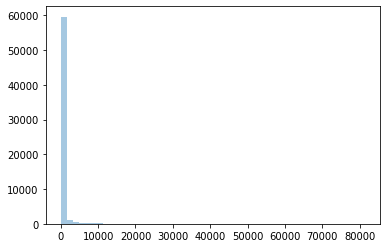

In [19]:
#display df1 using histogram
display(sns.distplot(df1.select('number_of_ratings').toPandas(), kde=False))

Most movies receive a small number of ratings. The minimum number of ratings received by movie is 0.

In [21]:
#distribution of number of movie rated by each user 
df2 = spark.sql("Select userId, count(movieId) as number_movie_rated from ratings group by userId")

In [22]:
#a quick check at the derived data 
df2.show(5)

+------+------------------+
userId|number_movie_rated|
+------+------------------+
 148| 132|
 463| 21|
 471| 39|
 496| 31|
 833| 158|
+------+------------------+
only showing top 5 rows

In [23]:
min_ratings_by_user = df2.toPandas()["number_movie_rated"].min()
print("Minimum number of ratings by user is: {}".format(min_ratings_by_user))

Minimum number of ratings by user is: 20

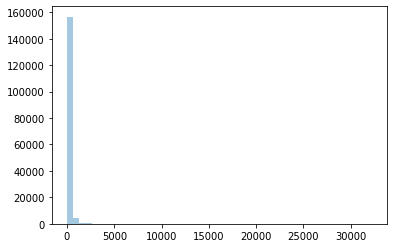

In [24]:
display(sns.distplot(df2.select('number_movie_rated').toPandas(), kde=False))

Most of the users have only rated a few number of movies. The minimum number of movies rated by a user is 20. A long tail problem is obvious both from looking at the user side and movie side.

In [26]:
#distribution of the genre
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.functions import desc

print('Counts of movies per genre')
movies.select(explode(split("genres", "|")))

movies.select('movieID', explode(split("genres", "[|]")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
 genres|count|
+------------------+-----+
 Drama|25606|
 Comedy|16870|
 Thriller| 8654|
 Romance| 7719|
 Action| 7348|
 Horror| 5989|
 Documentary| 5605|
 Crime| 5319|
(no genres listed)| 5062|
 Adventure| 4145|
 Sci-Fi| 3595|
 Children| 2935|
 Animation| 2929|
 Mystery| 2925|
 Fantasy| 2731|
 War| 1874|
 Western| 1399|
 Musical| 1054|
 Film-Noir| 353|
 IMAX| 195|
+------------------+-----+

###2. Prototying the ALS Models

In [28]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [29]:
from pyspark.sql.types import IntegerType, FloatType
ratings_df = ratings.drop("timestamp")
ratings_df = ratings_df.withColumn("userId", ratings_df["userId"].cast(IntegerType()))
ratings_df = ratings_df.withColumn("movieId", ratings_df["movieId"].cast(IntegerType()))
ratings_df = ratings_df.withColumn("rating", ratings_df["rating"].cast(FloatType()))

In [30]:
ratings_df.show(5)

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 1| 296| 5.0|
 1| 306| 3.5|
 1| 307| 5.0|
 1| 665| 5.0|
 1| 899| 3.5|
+------+-------+------+
only showing top 5 rows

In [31]:
train, validation, test = ratings_df.randomSplit([0.6,0.2,0.2],seed = 1234)

In [32]:
ranks = [6, 10]
maxIter = 10
regParam = [0.05, 0.2]

since the dataset is large and we have enough samples for validation set, we do not need to do cross-validation.

In [34]:
def train_ALS(train, validation, maxIter,regParam, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParam:
            als=ALS(rank=rank, maxIter=maxIter,
                    regParam=reg, userCol='userId',itemCol='movieId',ratingCol='rating',coldStartStrategy='drop',nonnegative=True)
            model=als.fit(train)
            predictions = model.transform(validation)
            evaluator=RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model


In [35]:
final_model = train_ALS(train, validation, maxIter, regParam, ranks)

6 latent factors and regularization = 0.05: validation RMSE is 0.8134454192839958
6 latent factors and regularization = 0.2: validation RMSE is 0.8609125573669407
10 latent factors and regularization = 0.05: validation RMSE is 0.8053287837509352
10 latent factors and regularization = 0.2: validation RMSE is 0.8605591931541517

The best model has 10 latent factors and regularization = 0.05

Ploting the learning curve to make sure that RMSE converges at 10 interations for the best model parameters.

In [37]:
def learning_curve(iter_list,train,validation,reg,rank):
  errors = []
  for iter in iter_list:
    als=ALS(rank=rank, maxIter=iter,
                    regParam=reg, userCol='userId',itemCol='movieId',ratingCol='rating',coldStartStrategy='drop',nonnegative=True)
    model=als.fit(train)
    predictions = model.transform(validation)
    evaluator=RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')
    error = evaluator.evaluate(predictions)
    errors.append(error)
  
  fig,ax = plt.subplots(1,1)
  ax.set_xlim(0, 10)
  ax.set_ylim(0,max(errors))
  ax.set_xlabel("number of iterations")
  ax.set_ylabel("RMSE")
  ax.set_xticklabels(ax.get_xticks())
  ax.set_yticklabels(ax.get_yticks())
  ax.plot(iter_list,errors)
  fig.show()
  

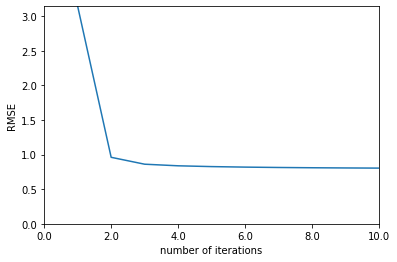

In [38]:
iter_list = list(range(1, maxIter+1))
learning_curve(iter_list, train, validation, 0.05, 10)

The RMSE is able to converge after the 2nd Iteration.

####3. Productionalize the Best Trained Model to Automate the Recommender System

In [41]:
def movieId(df_movies, fav_movies):
    """Return all movieId(s) of user's favorite movies
    @param df_movies: movies data
    @param fav_movies user's list of favorite movies 
    @type df_movies: spark dataframe
    @type fav_movies: list
    @return: a list of movieIds 
    """
    movieId_list = []
    for movie in fav_movies:
        movieId = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect() 
        movieId_list.extend(movieId)
    return list(set(movieId_list))


def add_new_user(train_data, movieId_list):
    """add new rows for new user based on movie preference to existing train data
    @param train_data:rating data
    @param movieId_list: list of movieIds
    @type train_data: spark Dataframe
    @type movieId_list: list
    @return new train data with new user's rows added
    """
    # get new user id
    new_id = train_data.rdd.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.rdd.map(lambda r: r[2]).max()
    # create new user data 
    new_user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_user_df = sqlContext.createDataFrame(new_user_rows, ('userId', 'movieId', 'rating'))
    # return new train data
    return DataFrame.unionAll(train_data, new_user_df)


def get_prediction_data(train_data, df_movies, movieId_list):
    """return a data with the new user id and all movies excluding the favorite movies that the user selected 
    @param train_data: ratings data
    @param df_movies: movies data
    @param movieId_list: list of movieIds
    @type train_data: spark Dataframe
    @type df_movies: spark Dataframe 
    @type movieId_list: list
    @return: inference data to make prediction on 
    """
    # get new user id
    new_id = train_data.rdd.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x)).toDF(["userId", "movieId"])


def train_best_model(best_model_params, df_ratings, df_movies, fav_movies):
    """return best fit models 
    @param best_model_params: {'iterations': iter, 'rank': rank, 'lambda_': reg}
    @param df_ratings: ratings data 
    @param df_movies: movies data
    @param fav_movies: user's list of favorite movies
    @type best_model_params: dic
    @type df_ratings: spark Dataframe
    @type df_movies: spark Dataframe
    @type fav_movies: list
    @return: fitted models based on the best model param
    """
    # modify train data by adding new user's rows
    movieId_list = movieId(df_movies, fav_movies)
    train_data = add_new_user(df_ratings, movieId_list)
    
    # train best ALS
    als=ALS(rank=best_model_params.get('rank', None), maxIter=best_model_params.get('iterations', None),
                    regParam=best_model_params.get('lambda_', None),
            userCol='userId',itemCol='movieId',ratingCol='rating',coldStartStrategy='drop',nonnegative=True)
    model=als.fit(train_data)
    
    return model 

def make_recommendations(best_model_params, df_ratings, df_movies, 
                        fav_movies, n_recommendations):
    """make top n movie recommendation based on user's favorite movies
    @param best_model_params: {'iterations': iter, 'rank': rank, 'lambda_': reg}
    @param df_ratings: ratings data 
    @param df_movies: movies data
    @param fav_movies: user's list of favorite movies
    @param n_recommendations: top n recommendations
    @type best_model_params: dic
    @type df_ratings: spark Dataframe
    @type df_movies: spark Dataframe
    @type fav_movies: list
    @type n_recommendations: int
    @return: top n recommendations 
    """
     
    #get the best model 
    model = train_best_model(best_model_params, df_ratings, df_movies, fav_movies)

    #get prediction data
    movieId_list = movieId(df_movies, fav_movies)
    inference = get_prediction_data(df_ratings, df_movies, movieId_list)
    
    #making predictions
    predictions = model.transform(inference).rdd.map(lambda r: (r[1], r[2]))
    
    #get top n movieId
    topn_predictions = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_predictions]
    
    #return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [42]:
#favorite movies
favorite_movies = ['Toy Story']

# get recommends
movie_recommends = make_recommendations(
    best_model_params={'iterations': 10, 'rank': 10, 'lambda_': 0.05}, 
    df_ratings=ratings_df, 
    df_movies=movies, 
    fav_movies=favorite_movies, 
    n_recommendations=10)

print('Other movies you might like if you like {}:'.format(favorite_movies[0]))
for i, title in enumerate(movie_recommends):
    print('{0}: {1}'.format(i+1, title))

Other movies you might like if you like Toy Story:
1: Presumed Guilty (Presunto culpable) (2008)
2: Traveling Executioner, The (1970)
3: Meet the Mormons (2014)
4: The Stationmaster Meets His Match (1980)
5: Don't Give a Damn (1995)
6: Veyyil (2006)
7: Uno: The Movie
8: Casus Belli (2010)
9: Art Bastard (2015)
10: Sonicsgate: Requiem For A Team (2009)